In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import h5py
from glob import glob

archive = h5py.File("../archive.hdf5", 'r')

In [3]:
# wl_min = 5101#5590
# wl_max = 5300#5610

class Spectrum(object): 
    def __init__(self, wl, fl): 
#         wl_range = ((wl < wl_max) & (wl > wl_min))
        self.wavelength = wl#[wl_range]
        self.flux = fl#[wl_range]

(0, 2)

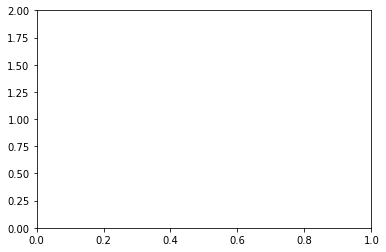

In [4]:
spectra = []
keys = list(archive)
for isot in keys: 
    sp = Spectrum(*archive[isot][:])
    spectra.append(sp)
    
#     if sp.flux.max() < 1.2:
#         plt.plot(sp.wavelength, sp.flux)

#tio = 5598.410

tio = control = 5208.5 #5603.8 #5594.6 #5602.9 #5593.75 #5594.5

# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 2])

In [5]:
spectra[0].wavelength

array([5159.07, 5159.08, 5159.09, ..., 5179.04, 5179.05, 5179.06])

In [5]:
# Expensive, only run once:
# dx = []
# for i in range(1, len(spectra)):
#     cross_corr = np.correlate(spectra[0].flux - np.median(spectra[0].flux), 
#                               spectra[i].flux - np.median(spectra[i].flux), mode='same')
    
#     dx.append(cross_corr.shape[0]//2 - cross_corr.argmax())

# np.save('dx.npy', dx)

dx = np.load('data/dx.npy')

In [6]:
from astropy.time import Time
dates = Time(keys, format='isot')

In [7]:
# for i, j in zip(dates.iso, all_fs): 
#     print(i, j)

In [8]:
from json import load
f_S = load(open('../f_S.json'))

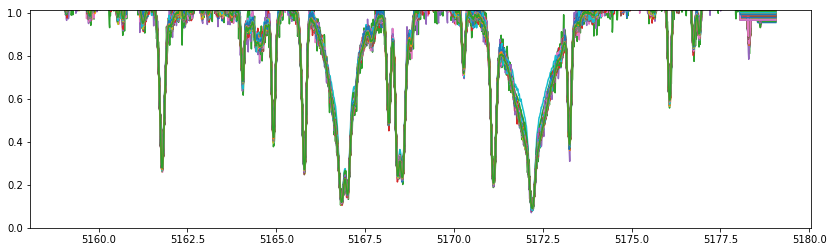

In [9]:
coadded = spectra[0].flux

spectral_grid = spectra[0].flux #np.zeros((len(spectra)-1, len(spectra[0].wavelength)))
all_fs = []

delta_wavelength = np.median(np.abs(np.diff(spectra[0].wavelength)))

spectra_indices = []

plt.figure(figsize=(14, 4))
for i in range(1, len(spectra)): 
    # Quality filter
#     if True:
    if spectra[i].flux.max() < 1.2:
        spectra_indices.append(i)
        date_key = str(dates[i-1].datetime.date())    
        all_fs.append(f_S[date_key])
        wavelength_shift = dx[i-1] * delta_wavelength
    
        rolled_spectrum = np.interp(spectra[0].wavelength, spectra[i].wavelength - wavelength_shift, spectra[i].flux, left=1, right=1)
        rolled_spectrum /= np.median(rolled_spectrum)

        plt.plot(spectra[i].wavelength, rolled_spectrum)
        coadded += rolled_spectrum
        
        spectral_grid = np.vstack([spectral_grid, rolled_spectrum])

coadded /= np.median(coadded)
        
# plt.xlim([tio - 5, tio + 5])
plt.ylim([0, 1.01])
spectra_indices = np.array(spectra_indices)

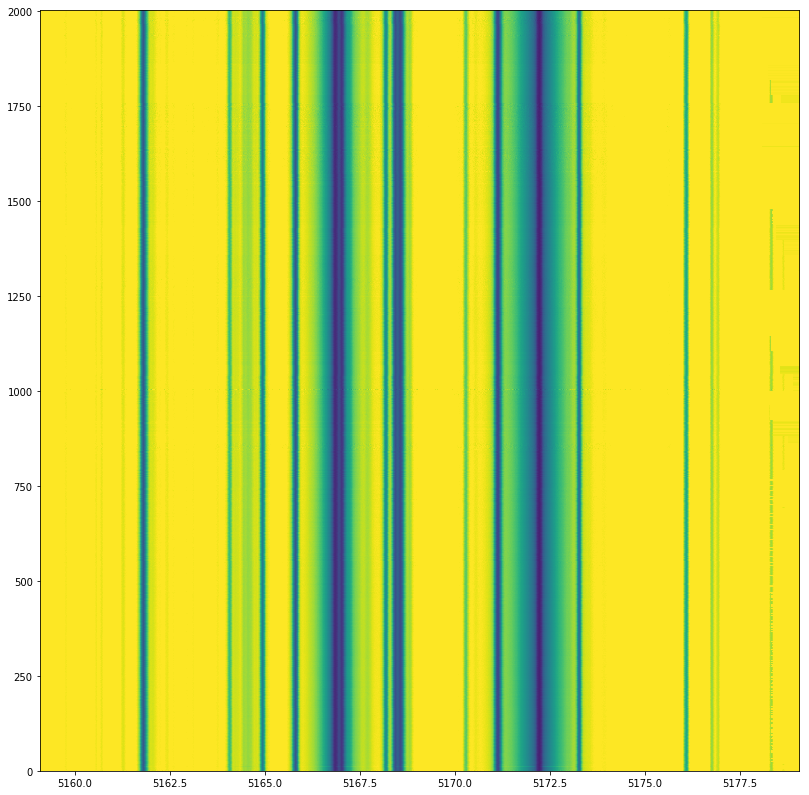

In [10]:
plt.figure(figsize=(14, 14))
extent = [spectra[0].wavelength.min(), spectra[0].wavelength.max(), 
          0, len(spectra_indices)]
plt.imshow(spectral_grid, origin='lower', extent=extent, vmin=0, vmax=1)
plt.gca().set_aspect(0.01)

In [11]:
sum_spectrum = np.median(spectral_grid, axis=0)

In [12]:
residuals = np.zeros_like(spectral_grid)

for i in range(spectral_grid.shape[0]): 
    X = np.vstack([spectra[i].flux, spectra[0].wavelength, np.ones(len(spectra[0].wavelength))]).T
    c = np.linalg.lstsq(X, sum_spectrum)[0]
    residuals[i, :] = X @ c - sum_spectrum
    
# Normalize residuals
residuals = residuals / residuals.ptp()

/Users/bmmorris/anaconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """


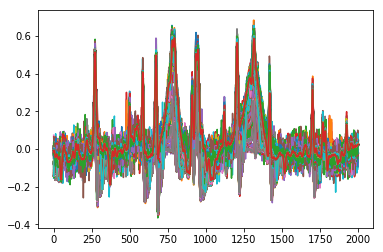

In [18]:
for residual in residuals: 
    residual -= np.median(residual)
    plt.plot(residual)
plt.show()

In [8]:
np.save('data/residuals.npy', residuals)
np.save('data/residuals_wl.npy', spectra[0].wavelength)

In [29]:
np.save('data/all_fs.npy', all_fs)

In [30]:
from scipy.stats import spearmanr

0.5128229866380493 8.898773063683815e-135


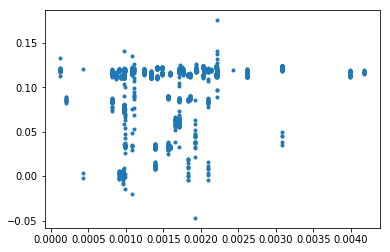

0.5062160016285782 8.058990111235741e-131


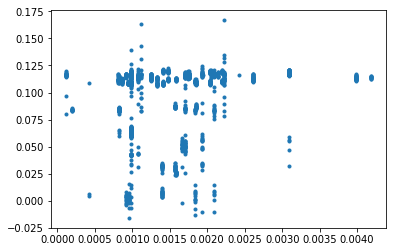

0.5176102102000802 1.0648658430907058e-137


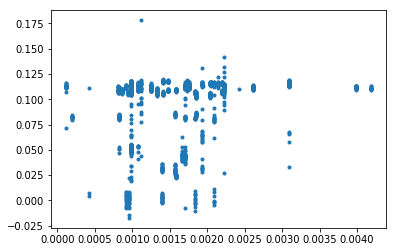

0.504118525253366 1.3943437950334417e-129


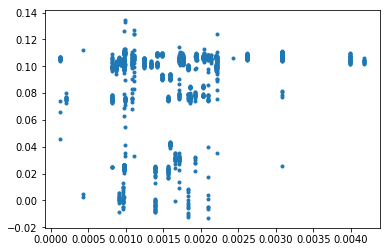

0.5138115264596694 2.2374866248033315e-135


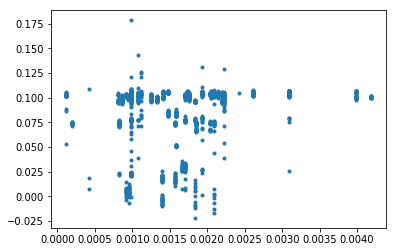

0.5160396368442037 9.797020868077778e-137


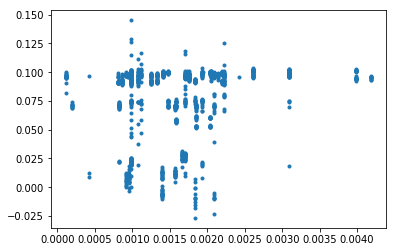

In [36]:
for channel in residuals.T: 
    r, p = spearmanr(channel[1:], all_fs)
    if r > 0.5:
        print(r, p)
        plt.plot(all_fs, channel[1:], '.')
        plt.show()